# Linking IFCB Targets to in-situ Data

The relocation of the U.S. National Science Foundation (NSF) Ocean Observatories Initiative (OOI) Coastal Pioneer (CP) Array from the [New England Shelf (NES)](https://oceanobservatories.org/array/coastal-pioneer-array) to the [Mid-Atlantic Bight (MAB)](https://oceanobservatories.org/array/coastal-pioneer-mid-atlantic-bight-array) introduced some new sensors to OOI. One of these, was the [Imaging FlowCytobot (IFCB)](https://ifcb-data.whoi.edu/about) originally developed at the [Woods Hole Oceanographic Institution (WHOI)](https://www.whoi.edu/) and now available commercially from [McLane Research Laboratories](https://mclanelabs.com).

This notebook was developed to help users interested in potentially exploring this instrument and the extensive data it will be producing over the next few years. While by no means an exhaustive review of how to process and analyze the IFCB data, it should help users at least get started. Addtionally, this notebook was developed to show users how additional co-located instrument data can be used to place the IFCB data into a larger environmental context.

#### More Information
https://www2.whoi.edu/staff/hsosik/ifcb/

## IFCB Utilities

Before this notebook can be run, code needed to access and process the IFCB data must be installed. The code we'll be using was developed at WHOI for processing data from the IFCB in preparation for displaying in in the [IFCB Dashboard](https://ifcb-data.whoi.edu/about). The same utilites can be used outside of the dashboard to analyze the IFCB data. Assuming the set up guide was used to configure the `ooi` conda environment, install the needed utilities:

``` shell
# activate the ooi conda environment
conda activate ooi

# obtain the pyIFCB code and add it to the environment
cd ~/code
git clone https://github.com/joefutrelle/pyifcb.git
cd pyifcb
conda env update --name ooi --file environment.yml
conda develop .
```

At this point, the `ooi` environment will be able to utilize the pyifcb tools (note, you may need to restart the notebook kernel to make them available). Documentation on how to use this code is [available](https://github.com/joefutrelle/pyifcb/wiki).

In [1]:
# import the ifcb module and other required modules
import glob
import ifcb
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### MAB Maintenance Cruise IFCB Data

For the OOI Coastal Pioneer MAB maintenance cruises, an IFCB will be installed inline with the ship's flow-thru system during transits to/from the array, and mounted on the ship's CTD rossette for discrete sampling alongside deployed moorings. Data collected by the ship's systems and the IFCB from these cruises will be added to the raw data directory after the maintenance cruise ends, making them available online via the [OOI Raw Data Server](https://rawdata.oceanobservatories.org/files/), or within the JupyterHub environment under the `/home/joyvan/ooi/uncabled/ship_data` directory. The recovered IFCB data will also be added to the [OOI IFCB Dashboard](https://ifcb-data.oceanobservatories.org/dashboard). 

The following is a quick example of how we can access the same data from the raw data directory, in this case focusing on a [randomly selected image](https://ifcb-data.oceanobservatories.org/image?image=00562&bin=D20240415T215238_IFCB206) from the discrete data collected next to the Central Surface Mooring (CP10CNSM) on 2024-04-15.

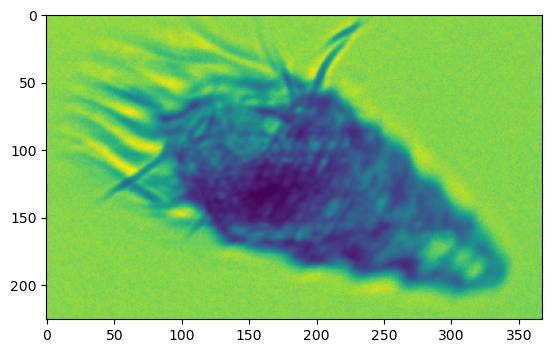

In [2]:
data_dir = ifcb.DataDirectory(os.path.join(os.path.expanduser('~'), 'ooi/uncabled/ship_data/pioneer-mab/Pioneer-20_AR82_2024-04-01/IFCB/discrete/'))
sample_bin = data_dir['D20240415T215238_IFCB206']
im = sample_bin.roi_file.get_image(562)
plt.imshow(im)

### Central Surface Mooring (CP10CNSM) IFCB Data

The IFCB sample data is comprised of 3 different files: a `.hdr` file (containing metadata), a `.adc` file (containing non-image data), and a `.roi` file (containing image data). File names include the date and time that the sample was run, and the instrument number identifying the IFCB that ran the sample. Due to telemetry constraints, the imagery data (the `.roi` files) will not be available until after the mooring is recovered and the data is downloaded from the IFCB. We cannot use all of the tools available in the pyIFCB code without all three files, however we can perform an initial analysis working with just the `.adc` files. These provide data about each target (image) collected during the sample run. We can use this data to generate some simple summary statistics (sample time, sample id, number of targets per sample, and mean target size) as well as a pandas dataframe containing all of the `.adc` data that we can use in any future work we might want to engage in with the IFCB data. The remainder of the this notebook will demonstrate some basic steps that we can take to access, organize and prepare this data for further analysis. In particular, how we can merge the IFCB with other co-located instrument data to place the IFCB data into a larger environmental context.

In [3]:
# raw data directory with the ADC files currently being telemetered to shore during the deployment
data_dir = os.path.join(os.path.expanduser('~'), 'ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240[456789]*.adc')
files = sorted(glob.glob(data_dir))  # listing of all the ADC files
files
# note, the file glob used above is constructed to deliberately exclude burn-in (aka parking lot) data

['/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240403T141609_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240403T152620_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240403T182514_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240403T212511_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240404T002511_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240404T032512_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240404T092532_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240404T122511_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240404T152510_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240404T182510_IFCB199.adc',
 '/home/jovyan/ooi/uncabled/CP10CNSM/D00001/cg_dat

In [4]:
%%time
# pull out the adc data from each adc file into a pandas dataframe and add the sampling date/time extracted from the file name
columns = 'TRIGGER ADC_TIME PMT_A PMT_B PMT_C PMT_D PEAK_A PEAK_B PEAK_C PEAK_D TIME_OF_FLIGHT GRAB_TIME_START GRAB_TIME_END ROI_X ROI_Y ROI_WIDTH ROI_HEIGHT START_BYTE COMPARATOR_OUT START_POINT SIGNAL_LENGTH STATUS RUN_TIME INHIBIT_TIME'.lower().split(' ')
columns = {index: value for index, value in enumerate(columns)}

full = []     # temporary list to hold the dataframes from each sampling run
summary = []  # summary results from each sampling run we can later merge with 
for file in files:
    # load the adc data and use the sample id to set the sampling time
    adc = ifcb.data.adc.AdcFile(file)
    sample_id = adc.lid
    sample_time = pd.Timestamp(sample_id[1:-8], tz='UTC')
    
    # convert the data to a pandas dataframe, rename the columns and drop any size 0 triggers
    adc = adc.to_dataframe()
    adc.rename(columns=columns, inplace=True)
    adc = adc[adc['roi_width'] > 0]
    
    # add the sample id and time that we can use later in grouping the data
    adc.insert(1, 'sample_id', sample_id)
    adc.insert(3, 'sample_time', sample_time)
    
    # append the results to the full and summary lists
    full.append(adc)
    area = (adc['roi_width'] / 2.7) * (adc['roi_height'] / 2.7)  # rough estimate of target area in um^2 (~2.7 pixels/um)
    summary.append([sample_time, sample_id, len(adc), np.mean(area)])

CPU times: user 4.64 s, sys: 806 ms, total: 5.45 s
Wall time: 5.45 s


In [5]:
%%time
# convert the full and summary lists into pandas dataframes
full = pd.concat(full, ignore_index=True)
full.index.rename('samples', inplace=True)

summary = np.array(summary)
summary = pd.DataFrame(summary[:, 1:], index=summary[:, 0], columns=['sample_id', 'target_counts', 'target_area'])
summary.index.rename('time', inplace=True)

CPU times: user 119 ms, sys: 112 ms, total: 231 ms
Wall time: 228 ms


In [6]:
%%time
grps = full.groupby('sample_id')
for grp in grps:
    pass

CPU times: user 170 ms, sys: 96.2 ms, total: 266 ms
Wall time: 263 ms


In [7]:
grp[1]

,trigger,sample_id,adc_time,sample_time,pmt_a,pmt_b,pmt_c,pmt_d,peak_a,peak_b,...,roi_y,roi_width,roi_height,start_byte,comparator_out,start_point,signal_length,status,run_time,inhibit_time
samples,,,,,,,,,,,,,,,,,,,,,
1327694,1,D20240908T082447_IFCB199,13.227146,2024-09-08 08:24:47+00:00,0.003120,0.000094,-0.001333,-0.000572,0.040121,0.006983,...,363,80,50,0,0,0,0,0,13.250093,0.092305
1327695,2,D20240908T082447_IFCB199,16.585882,2024-09-08 08:24:47+00:00,-0.000563,0.001192,-0.001274,-0.000490,0.011034,0.006933,...,275,72,42,4000,0,0,0,0,16.607257,0.176018
1327696,3,D20240908T082447_IFCB199,20.215007,2024-09-08 08:24:47+00:00,0.003167,0.010564,-0.001449,-0.000612,0.063007,0.225658,...,211,80,58,7024,0,0,0,0,20.237650,0.260334
1327697,4,D20240908T082447_IFCB199,21.193862,2024-09-08 08:24:47+00:00,0.029510,0.016214,-0.001584,-0.000778,0.527959,0.284219,...,811,88,50,11664,0,0,0,0,21.216565,0.344564
1327698,5,D20240908T082447_IFCB199,29.005974,2024-09-08 08:24:47+00:00,0.216472,0.024528,-0.001819,-0.000917,2.955668,0.253482,...,467,104,66,16064,0,0,0,0,29.027986,0.428743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327928,256,D20240908T082447_IFCB199,1180.133918,2024-09-08 08:24:47+00:00,-0.001410,0.006809,-0.001943,-0.000994,0.011747,0.165985,...,755,64,34,1028272,0,0,0,0,1180.171389,21.310039
1327929,257,D20240908T082447_IFCB199,1184.338946,2024-09-08 08:24:47+00:00,-0.000760,0.004164,-0.001826,-0.000913,0.011704,0.082428,...,643,80,50,1030448,0,0,0,0,1184.376667,21.392949
1327930,259,D20240908T082447_IFCB199,1187.834133,2024-09-08 08:24:47+00:00,-0.001387,0.002028,-0.001819,-0.000951,0.011561,0.007255,...,595,80,42,1034448,0,0,0,0,1187.872222,21.558162


In [8]:
summary

,sample_id,target_counts,target_area
time,,,
2024-04-03 14:16:09+00:00,D20240403T141609_IFCB199,3666,752.229549
2024-04-03 15:26:20+00:00,D20240403T152620_IFCB199,4443,650.288381
2024-04-03 18:25:14+00:00,D20240403T182514_IFCB199,4073,621.513348
2024-04-03 21:25:11+00:00,D20240403T212511_IFCB199,6864,575.412882
2024-04-04 00:25:11+00:00,D20240404T002511_IFCB199,7272,570.638079
...,...,...,...
2024-09-07 16:24:45+00:00,D20240907T162445_IFCB199,344,540.72798
2024-09-07 20:24:45+00:00,D20240907T202445_IFCB199,667,489.572498
2024-09-08 00:24:47+00:00,D20240908T002447_IFCB199,501,521.715417


## Merge the IFCB data with Co-Located Instrument Data

On it's own the IFCB data doesn't really mean much. It needs to be placed into a larger environmental context. We can use some of the utilities in the [ooi-data-explorations python code](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python) to quickly load and prepare select co-located instrument data to merge with the IFCB summary data. You can explore the information about the [Coastal Pioneer MAB array](https://oceanobservatories.org/array/coastal-pioneer-mid-atlantic-bight-array/) to get an idea about the diversity of instrumentation and data available. For this example, we are going to use data from a co-located CTD ([Sea-Bird Scientific SBE 16Plus V2 SeaCAT](https://www.seabird.com/sbe-16plus-v2-seacat/product?id=60761421598)) and dual-channel fluorometer and backscatter sensor ([Sea-Bird Scientific ECO Triplet](https://www.seabird.com/eco-triplet/product?id=60762467720)) to demo how we can load data from other sensors and then combine that data with the IFCB summary data.

In [9]:
# import a utility used to load data from the kdata directory
from ooi_data_explorations.common import load_kdata

# import utilites used to re-organize and prepare the CTDBP and FLORT data for further work
from ooi_data_explorations.uncabled.process_ctdbp import ctdbp_datalogger
from ooi_data_explorations.uncabled.process_flort import flort_datalogger

### [Sea-Bird Scientific SBE 16Plus V2 SeaCAT](https://www.seabird.com/sbe-16plus-v2-seacat/product?id=60761421598) (conductivity, temperature and depth)

In [10]:
%%time
ctd = load_kdata('CP10CNSM', 'RID27', '03-CTDBPC000', 'telemetered', 'ctdbp_cdef_dcl_instrument', '*.nc')
ctd = ctdbp_datalogger(ctd)

Loading and Processing Data Files: 100%|██████████| 119/119 [00:00<00:00, 297.67it/s]
Merging the data files into a single dataset
CPU times: user 236 ms, sys: 178 ms, total: 414 ms
Wall time: 681 ms


### [Sea-Bird Scientific ECO Triplet](https://www.seabird.com/eco-triplet/product?id=60762467720) (chlorophyll, optical backscatter and fluorometric dissolved organic matter)

In [11]:
%%time
flr = load_kdata('CP10CNSM', 'RID27', '02-FLORTD000', 'telemetered', 'flort_sample', '*FLORT*.nc')
flr = flort_datalogger(flr, burst=True)
# using burst-averaging here with the ECO Triplet data (sampled at 1 Hz for 3 minutes every 15 minutes) to reduce data volume

Loading and Processing Data Files: 100%|██████████| 119/119 [00:00<00:00, 134.90it/s]
Merging the data files into a single dataset
CPU times: user 34.3 s, sys: 1.04 s, total: 35.3 s
Wall time: 36.1 s


### Merging the Data

In [12]:
%%time
# create a merged data set, copying the source CTD data
merge = ctd.copy()

# interpolate the chlorophyll, FDOM and optical backscatter into the CTD record and add metadata
merge['estimated_chlorophyll'] = ('time', np.interp(ctd['time'], flr['time'], flr.estimated_chlorophyll))
merge['estimated_chlorophyll'].attrs = flr.estimated_chlorophyll.attrs
merge['fluorometric_cdom'] = ('time', np.interp(ctd['time'], flr['time'], flr.fluorometric_cdom))
merge['fluorometric_cdom'].attrs = flr.fluorometric_cdom.attrs
merge['optical_backscatter'] = ('time', np.interp(ctd['time'], flr['time'], flr.bback))
merge['optical_backscatter'].attrs = flr.bback.attrs

# interpolate the number of targets and estimated target size in the CTD record
smry = summary.to_xarray()
smry['time'] = pd.DatetimeIndex(smry['time'].values)
merge['target_counts'] = ('time', np.interp(ctd['time'], smry['time'], smry['target_counts'].astype(float)))
merge['target_counts'].attrs['units'] = 'counts'
merge['target_area'] = ('time', np.interp(ctd['time'], smry['time'], smry['target_area'].astype(float)))
merge['target_area'].attrs['units'] = 'um^2'

CPU times: user 11.6 ms, sys: 12 ms, total: 23.5 ms
Wall time: 19.9 ms


In [13]:
merge

<xarray.Dataset> Size: 21MB
Dimensions:                            (time: 217645)
Coordinates:
  * time                               (time) datetime64[ns] 2MB 2024-04-03T1...
Data variables: (12/13)
    sea_water_pressure                 (time) float32 871kB 6.877 7.11 ... 6.864
    deployment                         (time) int32 871kB 1 1 1 1 1 ... 1 1 1 1
    sea_water_electrical_conductivity  (time) float32 871kB 3.402 ... 5.601
    depth                              (time) float64 2MB 6.827 7.058 ... 6.814
    sea_water_density                  (time) float64 2MB 1.024e+03 ... 1.023...
    internal_timestamp                 (time) float64 2MB 1.712e+09 ... 1.723...
    ...                                 ...
    sea_water_temperature              (time) float32 871kB 9.749 9.731 ... 26.9
    estimated_chlorophyll              (time) float64 2MB 1.17 1.17 ... 0.4104
    fluorometric_cdom                  (time) float64 2MB 5.315 5.323 ... 2.515
    optical_backscatter                (time) float64 2MB 0.01295 ... 0.0028
    target_counts                      (time) float64 2MB 3.666e+03 ... 753.6
    target_area                        (time) float64 2MB 752.2 752.2 ... 826.7
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

### Plotting the Merged Data

Now that the data has all been merged, we can create a set of stacked timeseries plots for an initial review of the data

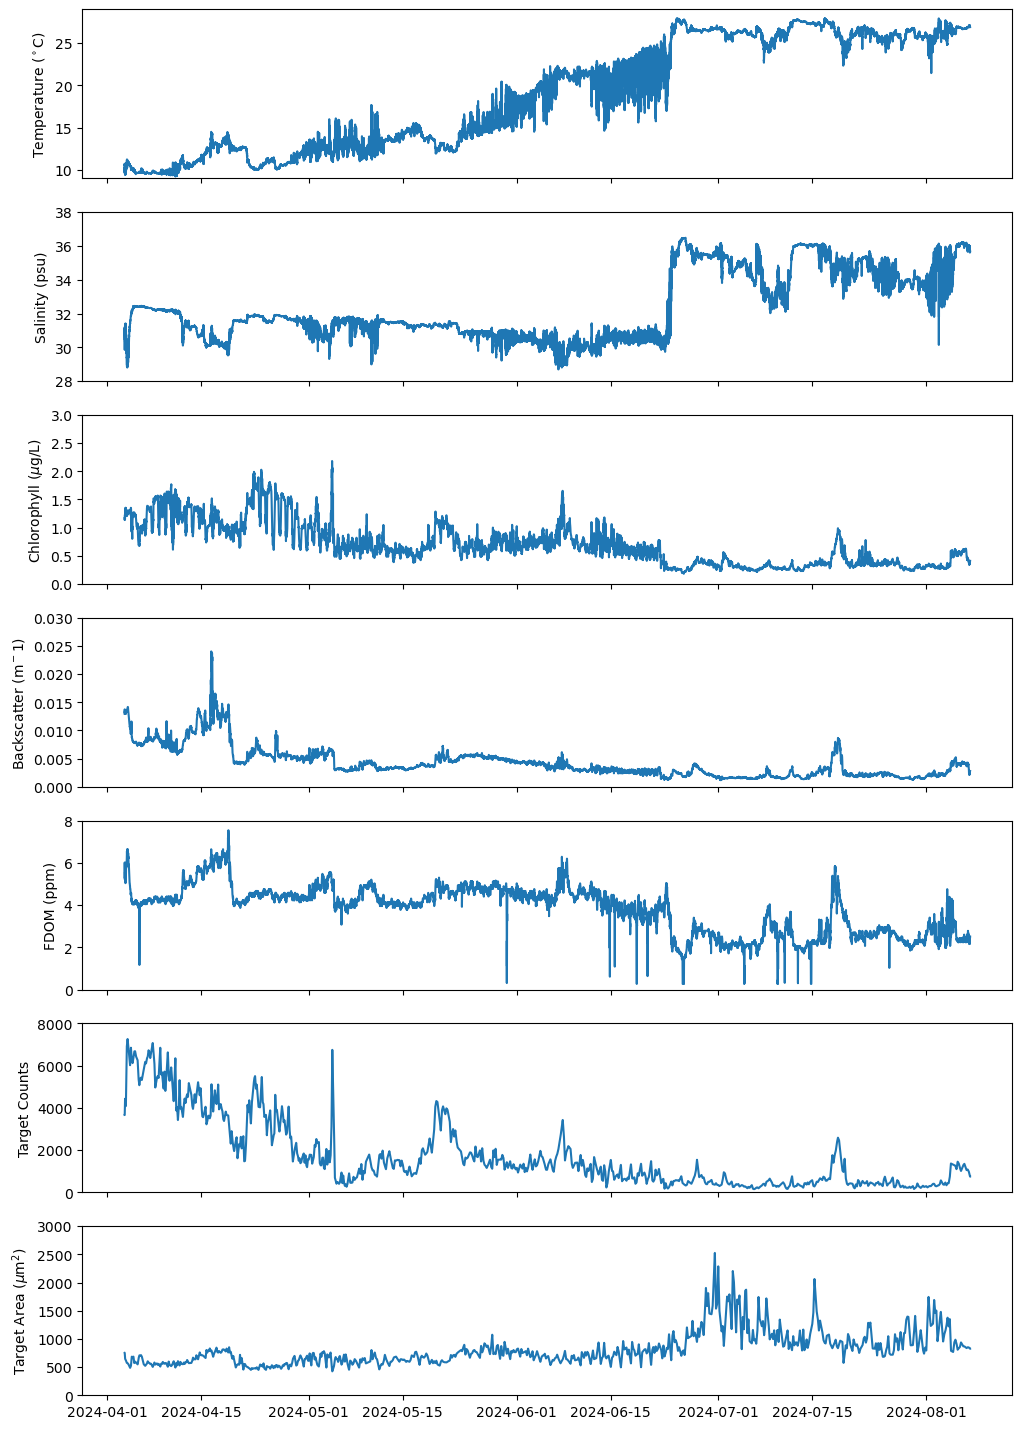

In [14]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(12, 18))

ax1 = plt.subplot(7, 1, 1)
plt.plot(merge.time, merge.sea_water_temperature)
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([9, 29])
plt.ylabel('Temperature ($^\circ$C)')

ax2 = plt.subplot(7, 1, 2, sharex=ax1)
plt.plot(merge.time, merge.sea_water_practical_salinity)
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([28, 38])
plt.ylabel('Salinity (psu)')

ax3 = plt.subplot(7, 1, 3, sharex=ax1)
plt.plot(merge.time, merge.estimated_chlorophyll)
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 3])
plt.ylabel('Chlorophyll ($\mu$g/L)')

ax4 = plt.subplot(7, 1, 4, sharex=ax1)
plt.plot(merge.time, merge.optical_backscatter)
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 0.03])
plt.ylabel('Backscatter (m$^-1$)')

ax5 = plt.subplot(7, 1, 5, sharex=ax1)
plt.plot(merge.time, merge.fluorometric_cdom)
plt.setp(ax5.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 8])
plt.ylabel('FDOM (ppm)')

ax6 = plt.subplot(7, 1, 6, sharex=ax1)
plt.plot(merge.time, merge.target_counts)
plt.setp(ax6.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 8000])
plt.ylabel('Target Counts')

ax6 = plt.subplot(7, 1, 7, sharex=ax1)
plt.plot(merge.time, merge.target_area)
plt.ylim([0, 3000])
plt.ylabel('Target Area ($\mu$m$^2$)')

plt.show()

### Looked at from a different direction

We can look at some of the data above, in particular the target counts and area, from a different perspective using a T/S diagram.

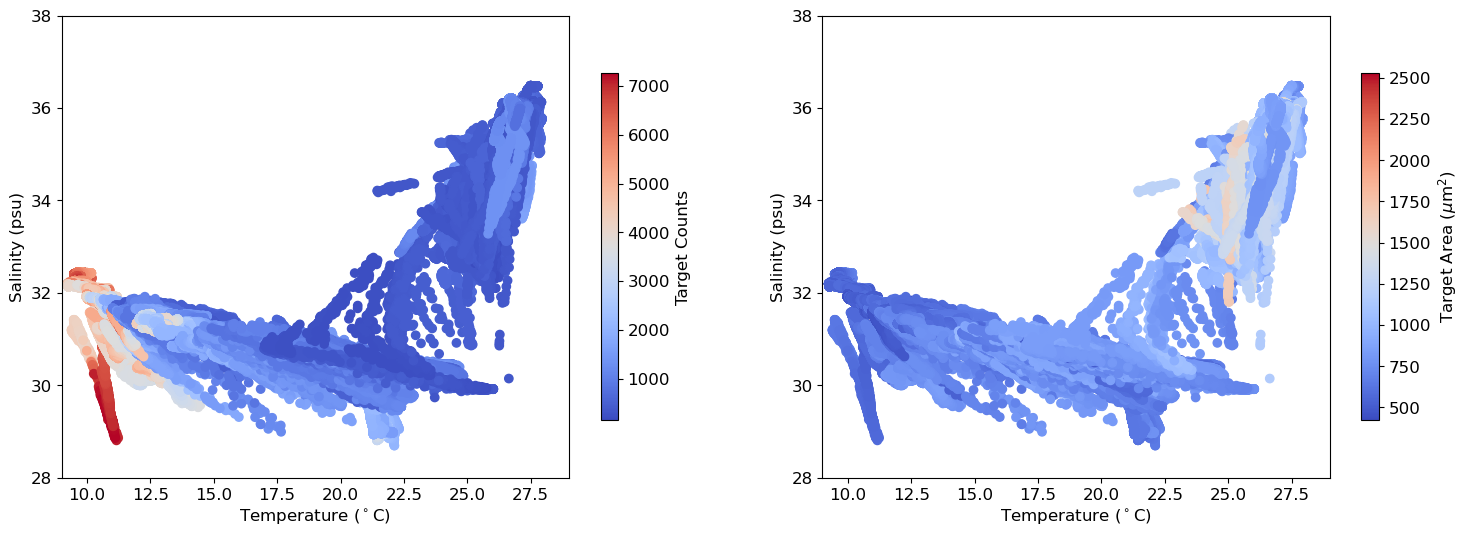

In [15]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(merge['sea_water_temperature'], merge['sea_water_practical_salinity'], c=merge['target_counts'], cmap='coolwarm')
cbar = plt.colorbar(shrink=0.75, label='Target Counts')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Salinity (psu)')
plt.xlim([9, 29])
plt.ylim([28, 38])

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.scatter(merge['sea_water_temperature'], merge['sea_water_practical_salinity'], c=merge['target_area'], cmap='coolwarm')
cbar = plt.colorbar(shrink=0.75, label='Target Area ($\mu$m$^2$)')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Salinity (psu)')

plt.show()

## Other Co-Located Instruments

The above example only uses two co-located instruments to provide an environmental context for the IFCB data. Other instruments on the NSIF that could be used, include:

| Measurement | Instrument | Depth | Reference Designator |
| :---: | :---: | :---: | :---: |
| Dissolved nitrate concentration | Sea-Bird Scientific SUNA V2 | 7 m | CP10CNSM-RID26-07-NUTNRB000 |
| Dissolved oxygen concentration | Aanderaa Optode 4831 | 7 m | CP10CNSM-RID27-04-DOSTAD000 |
| Downwelling spectral irradiance (7 wavelengths) | Sea-Bird Scientific OCR-507 | 7 m | CP10CNSM-RID26-08-SPKIRB000 |
| Particle size analyzer | Sequoia LISST-200X | 7 m | CP10CNSM-RID26-01-PRTSZA000 |
| Seawater pH (total scale) | Sunburst Sensors SAMI-pH | 7 m | CP10CNSM-RID26-06-PHSEND000 |

Additionally, surface meterological data, wave data, velocity profiles, bioacoustic profiles, surface pCO<sub>2</sub> (can extended to the NSIF if within the mixed layer), other carbonate sytem parameters derived from estimated argonite saturation and co-located pH (or surface pCO<sub>2</sub>), can all be used to help in understanding forces affecting the plankton community.

See the [CP10CNSM site description](https://oceanobservatories.org/site/cp10cnsm/) for a full listing of available instrumentation, and the [Coastal Pioneer MAB array description](https://oceanobservatories.org/array/coastal-pioneer-mid-atlantic-bight-array/) for more information about the array as a whole.